In [ ]:
s

## Neural network architecture

We saw previously DL models with **dense** neural network architectures: this is a stack of (fully connected) layers in a (deep) sequence.

When analysing image data, it turns out that a different neural network architecture is needed: **Convolutional Neural Networks** (abbreviated as **"CNN"**).

CNN share similarities with Dense Neural Networks:

- neurons (units)
- layers
- weights and biases (to be learned)
- loss function (e.g. crossentropy)
- optimizer (e.g. `SGD`)

Additionally, in CNNs there are also:

- Convolutional Layers
- Pooling Layers
- Flatten Layers

## Why Convolutional Neural Networks?

In Dense Neural Networks all the neurons are connected to each other. Therefore the number of parameters grows very fast.
For example, when we have images with 28 by 28 pixels in greyscale, we will end up having 784 (28 x 28 x 1) parameters to learn.
However, most images have way more pixels and they are not grey-scaled. For instance, color images in 4K Ultra HD will have 26,542,080 (4096 x 2160 x 3) parameters to learn.

Therefore, we can say that Dense Neural Networks are not scalable for image classification.
However, in images pixels that are close to each other tend to be correlated: this leads to the idea of **Convolutional Layers** and **Pooling Layers**.

Due to the fact that pixels are related to the adjacent and close pixels, convolution allows us to preserve the relationship between different parts of an image. Convolution is basically filtering the image with a smaller pixel filter to decrease the size of the image without losing the relationship between pixels. When we apply convolution to 5x5 image by using a 3x3 filter with 1x1 stride (1-pixel shift at each step) we end up with a 3x3 output (64% decrease in complexity: from 25 to 9 parameters to learn).

![cnn](https://drive.google.com/uc?id=1lEhMKTCXB38LKdJtDO8bSk6aNJHJUoD1)



## Importing libraries

We import the necessary libraries to build a DL NN for image recognition:

- import the Sequential model type from Keras: linear stack of neural network layers, to be used to build a feed-forward CNN
-  import the 'core' layers from Keras: layers that are used in almost any neural network
- import the CNN layers from Keras: convolutional layers to train the model on image data
- load the MNIST dataset

In [ ]:
import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K # needed for image_data_format()
from keras.datasets import mnist

# Input data

We load the data from the MNIST dataset, and assign them to the training and testing sets.

Image data is generally harder to work with than flat relational data. The MNIST dataset is a beginner-friendly intoduction to working with image data: it contains $70\,000$ labeled images of handwritten digits. These are grey-scale images, 28 x 28 pixels.

The MNIST dataset comprises $60\,000$ training observations and $10\,000$ test observations: the function `load_data()` automatically assigns these to the training and testing sets.

In [ ]:
# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[0:5000,]
y_train = y_train[0:5000]
X_test = X_test[0:1000,]
y_test = y_test[0:1000]

print("Size of the training set")
print(X_train.shape)
print("Size of the test set")
print(X_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
Size of the training set
(5000, 28, 28)
Size of the test set
(1000, 28, 28)


Data have been split into a **training** and a **testing set**, and within these into a **three-dimensional array** $X$ of **features** (samples x pixels x pixels) and a vector $y$ of labels (0-9 digits).

Each record in the 3-D array $X$ is a 28 x 28 matrix of grayscale intensities (1 byte = 8 bits = 0 - 255 values). Grayscale (black-n-white) images only use one color channel. Colour images use three channels (e.g. RGB) and each image (record) is therefore a 3-D matrix (pixels x pixels x 3).

First training label:  5


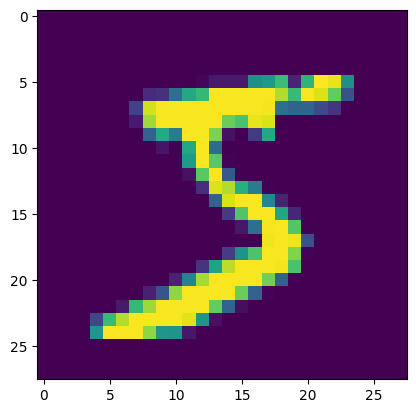

In [ ]:
print("First training label: ",y_train[0])

from matplotlib import pyplot as plt
plt.imshow(X_train[0])

By default the matplotlib function `imshow()` uses pseudocolors to plot grayscale images; if you want to display the actual grayscale image, you can specify the color mapping parameters:

First training label:  5


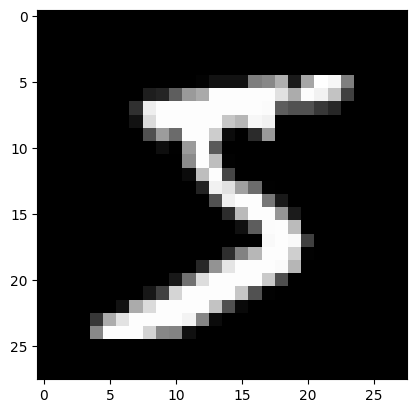

In [ ]:
print("First training label: ",y_train[0])
plt.imshow(X_train[0], cmap='gray', vmin=0, vmax=255)

#Configuration parameters

Define model parameters:

- batch size: DL models typically do not process the entire dataset at once, rather break it in **batches**
- n. of classes: n. of classes to predict (10 digits, in the MNIST problem)
- n. of epochs: n. of **iterations** over the entire dataset

In [ ]:
img_rows = 28 #pixels
img_cols = 28 #pixels
num_classes = 10
batch_size = 64
num_epochs = 100

# Data preprocessing

First, we need to explicitly declare the depth of the image representation array: in the case of grayscale images there is only one channel, and this dimension is 1.

We use the utility function [image_data_format()](https://keras.io/api/utils/backend_utils#imagedataformat-function) from keras [backend utilities](https://keras.io/api/utils/backend_utils/) to discover the convention ('channels_first' or 'channels_last') of our current system.

Depending on the backend (Theano or TensorFlow), the depth dimension is either the first or the last to be declared:

In [ ]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(1, X_train.shape[0], img_rows, img_cols)
    X_test = X_test.reshape(1, X_test.shape[0], img_rows, img_cols)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (28, 28, 1)

print("Modified array dimensions:")
print(X_train.shape)
print(input_shape)


Modified array dimensions:
(5000, 28, 28, 1)
(28, 28, 1)


We then convert the input data type to `float32` and normalize the data values to the range $[0, 1]$.
These are operational modifications necessary to speed up and optimize the calculations.

Finally, label vectors are converted to binary class matrices. This serves to convert a vector of numerical digits to a matrix of ten classes per observation, which is a better suited representation for a classification problem.

In [ ]:
#the "utils" subpackage is very useful, take a look to it when you have time
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 #max value of pixel intensity
X_test /= 255 #max value of pixel intensity
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices (also known as OHE - One Hot Encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (5000, 28, 28, 1)
5000 train samples
1000 test samples


In [ ]:
print(y_train[0:4]) ## print first four training examples (labels): which digits are these?

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


 # Model building

We now define our deep-learning **neural network architecture**, and start building our model for image recognition.

First, we declare a [sequential model](https://keras.io/guides/sequential_model/), that is a sequence of layers each with one input tensor and one output tensor.
Then we add a first convolutional layer ([Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/)) to our model; parameters are:

- number of convolution filters (n. of kernels to convolve with the input data)
- number of rows and columns in each convolution kernel
- type of activation function
- shape of the input array


In [ ]:
from tensorflow.keras import optimizers

model = Sequential() # topology
model.add(
          Conv2D(32, kernel_size=(3, 3),
          activation='relu',
          input_shape=input_shape))

print(model.output_shape) ## convolutional "padding" (28-(3-1) x 28-(3-1)) + 32 kernels (filters)

(None, 26, 26, 32)


The input shape is (60000, 28, 28, 1): 28 x 28 pixels, times 1 channel (grayscale), per 60,000 training samples.
The convolutional output shape is:

- None: not yet any samples trained (to be added later)
- 26 x 26: convolutional padding (3x3 kernel size $\rightarrow$ 28-2 x 28-2)
- 32: n. of convolutional filters (kernels)

Then we can add more layers to the deep-learning model:

- the [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) layer is a way to regularize our model to prevent overfitting
- [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) is a way to reduce the number of model parameters by sliding a 2x2 pooling filter across the previous layer and taking the max of the 4 values
- a [Dense](https://keras.io/api/layers/core_layers/dense/) layer whose first parameter is the output size of the layer (weights from the Convolution layers must be flattened -made 1-dimensional- before being passed on to the fully connected Dense layer)
- the final layer has an output size of 10 (the 10 classes of digits): the activation function here is [softmax](https://keras.io/api/layers/activations/#softmax-function) (the multiclass analog of the logistic function) which returns a probability for each class, e.g. 10% of chance of the sample belonging to class 1, 15% for class 2 and so forth. The sum of all probabilities adds to 100%

In [ ]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

- first convolutional layer: 3x3 filter x 32 filters +32 bias terms = 320 parameters
- second colnvolutional layer: 3x3 filter x 64 filters x 32 units (previous layer) + 64 bias terms = 18496 parameters
-  pooling layer: 2x2 --> reduces the dimensionality by half per ("convolved") image (from 24x24 to 12x12)
- dropout layer: randomly sets some units (neurons) to zero
- flatten: transforms 12x12x64 input tensor into a 1-D vector: 12 x 12 x 64 = 9216 output values
- dense layers: 128 units x 9216 inputs + 128 bias terms = $1\,179\,776$ parameters
- output layer: 10 units (classes) x 128 + 10 bias terms = 1290 parameters

### Compiling the model
When compiling the model we specify the **loss function** (here: [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)) and the **optimizer** (here: [Adadelta](https://keras.io/api/optimizers/adadelta/))

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

# Training the deep-learning model

We then fit the model on the training data, specifying:

- the batch size
- the number of epochs to train the model

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(X_test, y_test),
          verbose=1)

In [ ]:
 # history2 = model.fit(X_train, y_train,
 #          batch_size=batch_size,
 #          epochs=10,
 #          validation_data=(X_test, y_test),
 #          verbose=1)

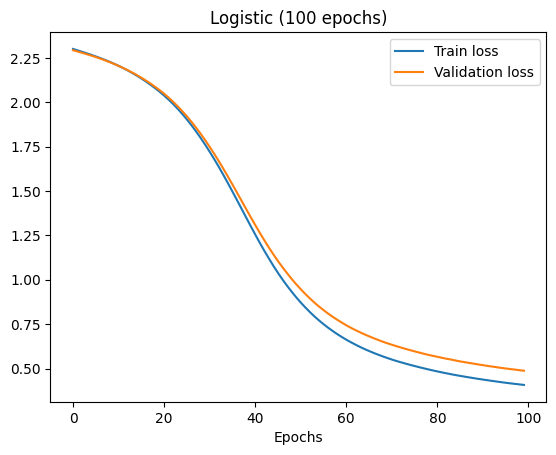

In [ ]:
def plot_loss_history(h, title):
    plt.plot(h.history['loss'], label = "Train loss")
    plt.plot(h.history['val_loss'], label = "Validation loss")
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

plot_loss_history(history, 'Logistic ({} epochs)'.format(num_epochs))

# Model evaluation

We can now measure the performance (in terms of prediction accuracy) of the trained deep-learning model for image recognition.
To measure the performance, we applied our trained model to independent test data.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.487646222114563
Test accuracy: 0.8640000224113464


In [ ]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.4057126045227051
Train accuracy: 0.8902000188827515


### Confusion matrix

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is another way to express the accuracy of your predictions. It's a square matrix, with as many rows (and columns) as your classes. Rows represent *true values* and columns represent *predicted values*. On the main diagonal are thus reported the correct predictions, while off-diagonal elements represent errors.

We'll use the [confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function part of [scikit-learn library](https://scikit-learn.org/stable/).

In [ ]:
#asking our model to return its predictions for the test set
predictions = model.predict(X_test)

#confusion_matrix function requires actual classes labels (expressed as int)
#and not probabilities as we handled so far
predicted_classes = predictions.argmax(axis=1)
true_classes = y_test.argmax(axis=1)

#rows are true values, columns are predicted values, numbering starts from zero
import sklearn.metrics
con_mat_df = sklearn.metrics.confusion_matrix(true_classes, predicted_classes)
print(con_mat_df)

32/32 [==============================] - 0s 2ms/step
[[ 80   0   0   0   0   0   2   0   1   2]
 [  0 119   1   4   0   0   0   0   2   0]
 [  0   1  96   2   0   0   2   3  10   2]
 [  0   0   0  91   0   5   2   3   5   1]
 [  0   0   0   0  87   0   5   1   2  15]
 [  2   0   0   2   2  73   1   2   3   2]
 [  3   0   3   0   2   3  76   0   0   0]
 [  1   4   4   0   1   0   0  83   0   6]
 [  1   1   0   4   2   2   0   3  72   4]
 [  0   1   0   2   0   0   0   1   3  87]]


Can you spot the most ambiguous, often confounded classes?

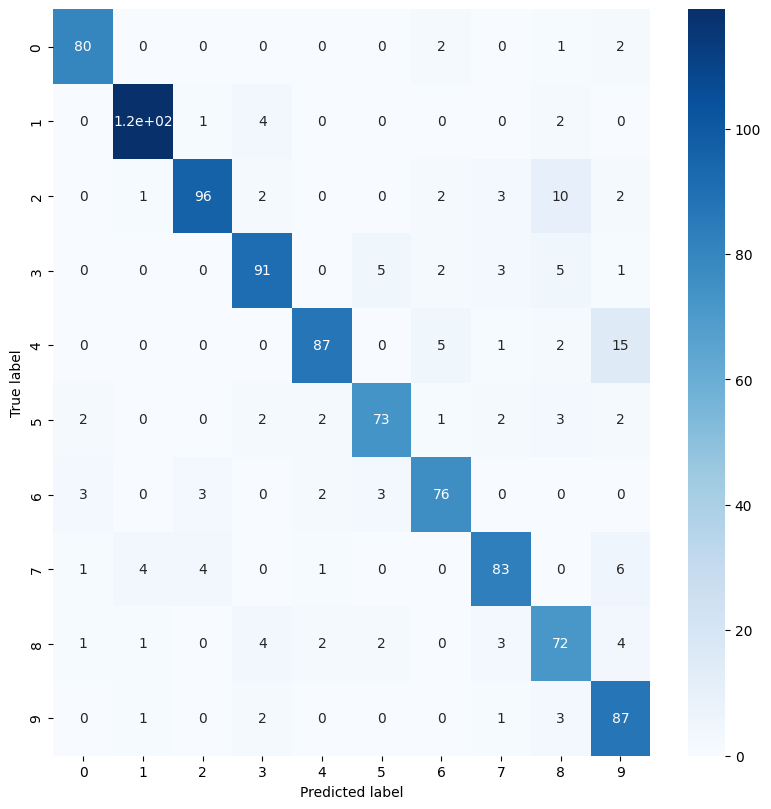

In [ ]:
import seaborn as sn

figure = plt.figure(figsize=(8, 8))
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Cohen's k

For multiclass classification problems we can also use other metrics to measure performance, like for instance `Cohen's kappa` (or `k`) (more info <a href='https://en.wikipedia.org/wiki/Cohen%27s_kappa'>here</a>)

In [ ]:
from sklearn.metrics import cohen_kappa_score

## training set
y_hat_training = model.predict(X_train)
y_class_training = y_hat_training.argmax(axis=1)
y_true_training = y_train.argmax(axis=1)
print(len(y_class_training))
k_train = cohen_kappa_score(y_class_training,y_true_training)
print("Cohen kappa in the training set is: ", k_train)

## test set
k_test = cohen_kappa_score(predicted_classes,true_classes)
print("Cohen kappa in the test set is: ", k_test)

157/157 [==============================] - 0s 3ms/step
5000
Cohen kappa in the training set is:  0.8779010998909117
Cohen kappa in the test set is:  0.8486873067564455


## Regularization

We have learnt that neural network models are prone to **overfitting**.
To counteract overfitting, a powerful strategy is to apply some kind of **regularization**.

Common regularization methods include **L1/L2 regularization** and **droput layers**

#### Dropout

![dropout](https://drive.google.com/uc?id=15Jtn_SZsysarGS-YgdkUkMhZC7EN7LmZ)

<font size="1">From: https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9</font>

We try now to apply dropout layers to our model for image recognition: will it improve the accuracy of predictions?

In [ ]:
## build and compile

model = Sequential() # topology
model.add(
          Conv2D(32, kernel_size=(3, 3),
          activation='relu',
          input_shape=input_shape))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
print(model.summary())

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(X_test, y_test),
          verbose=2)

In [ ]:
plot_loss_history(history, 'Logistic ({} epochs)'.format(num_epochs))

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7462767958641052
Test accuracy: 0.8090000152587891


In [ ]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.6378011107444763
Train accuracy: 0.8464000225067139


In [ ]:
predictions = model.predict(X_test)

predicted_classes = predictions.argmax(axis=1)
true_classes = y_test.argmax(axis=1)

con_mat_df = sklearn.metrics.confusion_matrix(true_classes, predicted_classes)

figure = plt.figure(figsize=(8, 8))
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
## training set
y_hat_training = model.predict(X_train)
y_class_training = y_hat_training.argmax(axis=1)
y_true_training = y_train.argmax(axis=1)
print(len(y_class_training))
k_train = cohen_kappa_score(y_class_training,y_true_training)
print("Cohen kappa in the training set is: ", k_train)

## test set
k_test = cohen_kappa_score(predicted_classes,true_classes)
print("Cohen kappa in the test set is: ", k_test)

157/157 [==============================] - 0s 2ms/step
5000
Cohen kappa in the training set is:  0.8291088659299419
Cohen kappa in the test set is:  0.7873167277063946


**Question: what happened with dropout regulartization? What did you notice? Why?**

---

## Exercise: L1/L2 regularization

Try to add L1/L2 regularization to the neural network model:

- L1: *Lasso* penalization
- L2: *Ridge* penalization

#### L1 regularization

$$
\text{cost} = \sum_{i=1}^n \left( y_i - \sum_{j=1}^p \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^p |\beta_j| = \text{RSS} + \text{L1-penalty}
$$


#### L2 regularization

$$
\text{cost} = \sum_{i=1}^n \left( y_i - \sum_{j=1}^p \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^p \beta_j^2 = \text{RSS} + \text{L2-penalty}
$$


**Question: what changes with L1/L2 regularization? How is the performance of the model changed?**

Here's an example of the Keras Tensorflow syntax to add L1/L2 regularization to a neural network model:

`model.add(Dense(n_units, kernel_regularizer=regularizers.l1/l2(lambda)))`

Hints: you can try to add more layers and units to make the model overfit the data, and then see if you can counteract this effect with regularization.

In [ ]:
## Example syntax to add l1/l2 regularization
## model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01)))

from tensorflow.keras import regularizers
## YOUR CODE HERE

model = Sequential() # topology
